In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus as pdp
import pickle
%matplotlib inline

In [2]:
##コメントカキコミ版
## 2021.10.7: created based on List_Enumeration.ipynb
    # インスタンス変数の説明
    # - model = [rule1, ..., ruleL] : ルールのリスト．
    #   ここに，末尾のルールはデフォールトルール ruleL = (True, label)
    # - ifrule : 対(cond, label)．単一のif-then規則．(term => label)を表す
    # - term = {'feature':Feats, 'value':Vals} : 論理積(term)の条件条件
    #  　改訂案：Feats == Vals == []のとき，のとき，term == Trueとみなすとよい．
    # - Feats = [Feat1, ..., FeatK] : K個の属性（int）からなるリスト
    # - Vals = [Val1, ..., ValK] in {0,1}^K : K個のブール値(0,1)からなるリスト
    # - (Feats, Vals) : ブール等式条件 "Feats == Vals" を表す
class RuleList(object):
    def __init__(self, feature_name):
        self.model         = []
        self.feature_name  = feature_name
        self.default_label = None  #computed by split()

    # ifrule := (rule, label)
    def append_ifrule(self, ifrule):
        return self.model.append(ifrule)
    
    def append_default_label(self, lab):
        self.default_label = lab
    
    # ルールの追加
    # 入力  
    # - x    : データ（numpy ndarray）     
    # - y    : ラベル（numpy ndarray）
    # - rule : ルール　（dict, 例 : {'feature':[1, 2], 'value':[0, 1]}(means X1=0 & X2=1)）
    # 入力されたルールをモデルに追加する関数
    def add_rule(self, X, y, rule):
        S = np.arange(len(X))
        #print(S)
        
        self.model.append([rule, None])
        #print(self.model)

        for i in range(len(self.model)):
            S_child = self.split(S, X, self.model[i][0])
            if (i+1)!=len(self.model): 
                S = np.setdiff1d(S, S_child)

        if len(S_child) != 0:
            label = self.labeling(S_child, y)
            self.model[-1] = [rule, label]
        else: del self.model[-1]
    
    # 予測
    def predict(self, X):
        pred  = []
        for row in X:
            pred_i = self.flow(row)
            pred.append(pred_i)

        return np.array(pred)

    def __str__(self):
        text = ""
        for i in range(len(self.model)):
            rule = self.model[i][0]
            feature = rule["feature"]
            value = rule["value"]

            text += "if "
            for j in range(len(feature)):
                text += str(feature[j]) + " == " + str(value[j])
                if j+1 != len(feature): text += " & "
            
            text += ", then " + str(self.model[i][1]) + "\n"
        
        text += "else predict " + str(self.default_label)

        return text

    # 入力された規則に従うデータのインデックスを返す関数
    def split(self, S, X, rule):
        f_name = rule["feature"]
        feature = []
        for j in f_name:
            feature.append(self.feature_name.index(j))


        value = rule["value"]

        if feature == False: return S

        for i in range(len(feature)):
            x_value = X[S][:, feature[i]]
            index = np.where(x_value == value[i])
            S = S[index]

        return S

    # 入力されたインデックスからラベルを返す関数
    def labeling(self, S, y):
        return round( sum(y[S]) / len(y[S]) )

    # １行のデータをモデルに入力し、対応するラベルを返す関数
    def flow(self, x):
        for i in range(len(self.model)):
            cond = self.model[i][0]
            f_name = cond["feature"]
            feat = []
            for j in f_name:
                feat.append(self.feature_name.index(j))
            val = cond["value"]
            #print(rules)


            if all(x[feat]==val): return self.model[i][1]

        return self.default_label

    # 要検討
    # deep_copyをする関数を自分で実装したい
    # 一次元のリストに関しては、スライスを用いることでコピー可能
    # 2次元のリストに関しては、スライスでは不可能
    # 暫定的（10/9）deepcopy関数を使用
    def deep_copy(self):
        model_copy = copy.deepcopy(self.model)
        return model_copy

    def length(self):
        return len(self.model)

    def supp(self):
        f = []
        for i in range(len(self.model)):
            cond = self.model[i][0]
            f.append(cond)

        return f

    def label(self):
        l = []
        for i in range(len(self.model)):
            c_label = self.model[i][1]
            l.append(c_label)
        l.append(self.default_label)

        return l

In [3]:
# グローバル変数
# - best_score : 最適な決定リストのスコア
# - S : 事前にマイニングしたルール
# - max_rule : ルール数の最大値
# - file_name : モデルとスコアを書き込むファイルの名前
# - eps : 羅生門集合のパラメータ
# - theta : 目的関数のパラメータ
class RecCORELS(object):
    # クラス名の案：RuleListEnumerator
    def __init__(self, best_score = 0.0, Terms = None, max_rule = 1, feature_name=None, eps=0, theta=0):
        self.best_score   =  best_score
        self.Terms        =  Terms        #事前にマイニングしたtermのリスト Terms = [term1, ..., termM]
        self.max_rule     =  max_rule - 1 #default_rule の分を除くため
        self.feature_name =  feature_name
        self.eps          =  eps
        self.theta        =  theta
        self.RS           =  []  # the Rashomon Set = a list of rulelists
        self.best_model   =  []

    #C4.5の標準的なサンプルの分割関数 split
    # 旧：入力された規則に従うデータのインデックスを返す関数
    # 新：S1（term がTrueとなるデータの添字リスト）, S0（Falseとなるデータの添字リスト）
    # 入力
    # SI : データ行列Xの行添字の集合
    # term : 論理積を実装する辞書{'feature', 'value'}
    # X : データ行列
    # term（rule)の辞書表現はそのまま使うこと
    def split_indexlist_by_a_term(self, SI, term, X): 
        """ 添字リストリストSを，
            論理積term
            term = {'feature':Feats, 'value':Vals}
            で次の二つに分割する
            S1 ：termがTrueになる添字のリストのリスト
            S0 ：termがFalsになる添字のリストのリスト
        """
        #書き直しのひつようあり
        #10/9 書き直し
        feat_name = term["feature"]
        feat = []
        for j in feat_name:
            feat.append(self.feature_name.index(j))

        val = term["value"]

        if feat == []: return np.array([]), SI

        X_index = X[SI]
        index = np.where(X_index[:, feat] == val)[0]
        uniq, count = np.unique(index, return_counts=True)
        child = np.array(uniq[count == len(feat)])
        S1 = SI[child]
        S0 = np.setdiff1d(SI, S1)
        return S1, S0

    def findRashomonSet(self, X, y):
        #Termsはtermsのリスト
        #featureNames = []
        d = RuleList(self.feature_name)
        SI  = np.arange(len(X)) # 全ての行の添字のリスト
        TI  = np.arange(len(self.Terms)) # Termsの全て添字のリスト
        self.RS = [] #the empty Rashomon set
        self.enumRules(d, SI, TI, X, y) # dとSが変化する; X, yは定数

        return self.RS

    def enumRules(self, d, SI, TI, X, y):
        """
        入力：：
        - d : ルールリスト
        - S : 添字リスト
        - TI : 前処理で見つけたターム（アイテム集合）のリストTermsの添字リスト
        出力：なし
        """

        if (len(self.RS)%10000 == 0): print(len(self.RS))

        # Step a. 親モデル d の処理をする．dは末尾ラベル（default_label）なし
        # Step a.1. dの末尾なしスコアriskと，末尾ありスコア対drisk[0..1]を計算する
        risk, drisk = self.score(d, X, y)  #X上の上のglobal score
        #print(d)
        #print(risk, drisk)
        

        # Step a.2 default label dlab in {0,1}についてそれぞれルールを生成する
        for dlab in range(2):
            #d_with_default = d.deep_copy()  ## d_with_default
            #d_df = d_with_default.append_default_label(dlab)
            d_with_default = copy.deepcopy(d)
            d_with_default.append_default_label(dlab)
            #d_df = d.append_default_label(dlab)
            risk_df = drisk[dlab]
            self.RS.append((d_with_default, risk_df)) ## 対(d, R)を解集合に加える
        
        #枝刈り1：ベストスコアよりすでに悪い
        if risk >= (self.best_score + self.eps): 
            print("prune1")
            return

        # 枝刈り2：長さがすでに上限
        if d.length() >= self.max_rule:
            return

        # Step b. dの子に対して探索する
        for tid in TI: #あらかじめマイニングしたtermのこと
            #Step b.1 分岐条件
            term = self.Terms[tid] #添字tidのtermを取り出す
            TI_next = np.delete(TI, np.where(TI==tid)[0]) # 線形探索ででO(|TI|)かかるので全体で|TI|^2 => python気にしない

            #Step b.2 データ添字リストの分岐
            SI_child, SI_next = self.split_indexlist_by_a_term(SI, term, X) # SI_child = S1, SI_next = S0
            #print("0")
            if len(SI_child) == 0: 
                #print(SI, SI_child)
                continue
            # note: 今回S_childはつかわない

            #Step b.3 子の生成
            for label in range(2): #label in {0,1}
                #b.3.1 子のルールリストを新しく生成する
                d_next = copy.deepcopy(d)  #rulelist全体のコピーをとる．
                d_next.append_ifrule([term, label])

                #b.3.2 子について再起呼び出しする
                self.enumRules(d_next, SI_next, TI_next, X, y)       
        return 

    def score(self, d, X, y):
        pred = d.predict(X)
        err = 0
        err_default = [0, 0] 
        ## err_default[lab] 
        ## := デフォールトラベルがlabのときのデフォールトノードにおけるエラー数
        ## == デフォールトにおちるラベルlabのデータ数を保持
        for i in range(len(y)):
            if pred[i]==None: #default
                if y[i]==1:
                    err_default[0] += 1 #lab == 0のときのエラー数
                else: ##y[i]==0のとき
                    err_default[1] += 1 #lab == 1のときのエラー数
            elif y[i]!=pred[i]: #disagree
                err += 1
            else: #agree
                pass
        #ob_score = err + self.theta * len(d)
        leng = d.length()
        risk = err + (self.theta * leng)
        drisk = [0,0]
        for dlab in range(2):
            drisk[dlab] = risk + err_default[dlab]
        return risk, drisk

In [4]:
##211007 又くん，有村で打ち合わせ
## 改訂案改訂案
## 名前の変更
## - RuleList => RecCORELS
## -         return None

# グローバル変数
# - best_score : 最適な決定リストのスコア
# - S : 事前にマイニングしたルール
# - max_rule : ルール数の最大値
# - file_name : モデルとスコアを書き込むファイルの名前
# - eps : 羅生門集合のパラメータ
# - theta : 目的関数のパラメータ
class RecLawler(object):
    # クラス名の案：RuleListEnumerator
    def __init__(self, best_score = 0.0, Terms = None, max_rule = 10, feature_name=None, termid=None, eps=0, theta=0):
        self.best_score   =  best_score
        self.Terms        =  Terms        #事前にマイニングしたtermのリスト Terms = [term1, ..., termM]
        self.max_rule     =  max_rule - 1 #default rule の分 -1
        self.feature_name =  feature_name
        self.eps          =  eps
        self.theta        =  theta
        self.RS           =  []  # the Rashomon Set = a list of rulelists
        self.best_model   =  []
        self.termid       =  termid

    #C4.5の標準的なサンプルの分割関数 split
    # 旧：入力された規則に従うデータのインデックスを返す関数
    # 新：S1（term がTrueとなるデータの添字リスト）, S0（Falseとなるデータの添字リスト）
    # 入力
    # SI : データ行列Xの行添字の集合
    # term : 論理積を実装する辞書{'feature', 'value'}
    # X : データ行列
    # term（rule)の辞書表現はそのまま使うこと
    def split_indexlist_by_a_term(self, SI, term, X): 
        """ 添字リストリストSを，
            論理積term
            term = {'feature':Feats, 'value':Vals}
            で次の二つに分割する
            S1 ：termがTrueになる添字のリストのリスト
            S0 ：termがFalsになる添字のリストのリスト
        """
        #書き直しのひつようあり
        #10/9 書き直し
        feat_name = term["feature"]
        feat = []
        for j in feat_name:
            feat.append(self.feature_name.index(j))

        val = term["value"]

        if feat == []: return np.array([]), SI

        X_index = X[SI]
        #print("X_index", feat)
        #print(X_index[:, feat])
        #print()
        index = np.where(X_index[:, feat] == val)[0]
        uniq, count = np.unique(index, return_counts=True)
        child = np.array(uniq[count == len(feat)])
        #x_value = x[S][:, feat]]
        #index = np.where(x_value == val)
        S1 = SI[child]
        S0 = np.setdiff1d(SI, S1)
        return S1, S0

    def enumModel(self, X, y):
        # term_list : モデルの学習に使用できるターム
        #　use_term : モデルが使用したターム
        #
        #
        
        enum_list = []
        TI  = np.arange(len(self.Terms))
        base_model, score = self.findBestmodel(X, y, TI)
        print("-"*100)
        enum_list.append([base_model, TI, [], score])
        solution_set = []
        #print(base_model.supp())
        a = np.array(base_model.supp())
        Te = np.array(self.Terms)
        #print(a[1]["feature"])
        #print(np.where(Te==a[1]["feature"])[0])
        #print(self.termid.index(a[0]["feature"]))

        K = 40
        supp_list = []
        while len(enum_list)!=0:
            
            A = [ row[3] for row in enum_list ]
            index = A.index(min(A))
            
            pop_list = enum_list.pop(index)
            #print("pop", pop_list)
            m, T, F, m_acc = pop_list

            #solution_set.append(m)
            #print("T, F", T, F)

            l = []
            for i in range(len(m.supp())):
                l.append(m.supp()[i]["feature"])
            
            if l in supp_list: continue
                
            print(l)
            print(supp_list)
            print()
            
            solution_set.append([m, m_acc])
            supp_list.append(l)
            
            t = np.array(m.supp())
            
            if len(solution_set) == K: break
            
            for i in range(len(t)):
                ti = self.termid.index(t[i]["feature"])
                if ti in F: continue
                #print("index", ti)

                T_next = np.delete(T, np.where(T==ti)[0])
                #print("nowTerm, nextTerm", T, T_next)
                m_prime, score = self.findBestmodel(X, y, T_next)
                use = copy.deepcopy(F)
                enum_list.append([m_prime, T_next, use, score])
                F.append(ti)
                #print("enum_list", enum_list)
                #print()

        return solution_set


    def findBestmodel(self, X, y, TI):
        #Termsはtermsのリスト
        #featureNames = []
        d = RuleList(self.feature_name)
        self.best_score = len(X)
        SI  = np.arange(len(X)) # 全ての行の添字のリスト
        #TI  = np.arange(len(self.Terms)) # Termsの全て添字のリスト
        self.findBest(d, SI, TI, X, y) # dとSが変化する; X, yは定数
        #print("corels tid", TI)
 
        return self.best_model, self.best_score   
    
    def findBest(self, d, SI, TI, X, y):
        """
        入力：：
        - d : ルールリスト
        - S : 添字リスト
        - TI : 前処理で見つけたターム（アイテム集合）のリストTermsの添字リスト
        出力：なし
        """

        #if (len(self.RS)%500 == 0): print(len(self.RS))

        # Step a. 親モデル d の処理をする．dは末尾ラベル（default_label）なし
        # Step a.1. dの末尾なしスコアriskと，末尾ありスコア対drisk[0..1]を計算する
        risk, drisk = self.score(d, X, y)  #X上の上のglobal score
        #print(d)
        #print(risk, drisk)
        
        #枝刈り1：ベストスコアよりすでに悪い
        if risk >= self.best_score: 
            return

        if min(drisk) < self.best_score:
            self.best_score = min(drisk)
            dlab = drisk.index(min(drisk))
            d_best = copy.deepcopy(d)
            d_best.append_default_label(dlab)
            self.best_model = copy.deepcopy(d_best)

        # 枝刈り2：長さがすでに上限
        if d.length() >= self.max_rule:
            return

        # Step b. dの子に対して探索する
        #print("TI", TI)
        #print(TI)
        for tid in TI: #あらかじめマイニングしたtermのこと
            #Step b.1 分岐条件
            term = self.Terms[tid] #添字tidのtermを取り出す
            TI_next = np.delete(TI, np.where(TI==tid)[0]) # 線形探索ででO(|TI|)かかるので全体で|TI|^2 => python気にしない
            #print("tid, TI_next", tid, TI_next, term)

            #Step b.2 データ添字リストの分岐
            SI_child, SI_next = self.split_indexlist_by_a_term(SI, term, X) # SI_child = S1, SI_next = S0
            #print("0")
            if len(SI_child) == 0: 
                #print(SI, SI_child)
                continue
            # note: 今回S_childはつかわない

            #print("check")
            #Step b.3 子の生成
            label = round( sum(y[SI_child]) / len(SI_child) ) 
            #b.3.1 子のルールリストを新しく生成する
            d_next = copy.deepcopy(d)  #rulelist全体のコピーをとる．
            d_next.append_ifrule([term, label])

                #b.3.2 子について再起呼び出しする
            self.findBest(d_next, SI_next, TI_next, X, y)
        #print("end")        
        return 

    def score(self, d, X, y):
        pred = d.predict(X)
        err = 0
        err_default = [0, 0] 
        ## err_default[lab] 
        ## := デフォールトラベルがlabのときのデフォールトノードにおけるエラー数
        ## == デフォールトにおちるラベルlabのデータ数を保持
        for i in range(len(y)):
            if pred[i]==None: #default
                if y[i]==1:
                    err_default[0] += 1 #lab == 0のときのエラー数
                else: ##y[i]==0のとき
                    err_default[1] += 1 #lab == 1のときのエラー数
            elif y[i]!=pred[i]: #disagree
                err += 1
            else: #agree
                pass
        #ob_score = err + self.theta * len(d)
        leng = d.length()
        risk = err + (self.theta * leng)
        drisk = [0,0]
        for dlab in range(2):
            drisk[dlab] = risk + err_default[dlab]
        return risk, drisk

In [5]:
train = pd.read_csv("../data/compas_train_race_preprocessed.csv", index_col=0)
train.head()

,race,recidivate-within-two-years,sex:Male,sex:Female,age:18-20,age:21-22,age:23-25,age:26-45,age:>45,juvenile-felonies:=0,...,juvenile-misdemeanors:=0,juvenile-misdemeanors:>0,juvenile-crimes:=0,juvenile-crimes:>0,priors:=0,priors:=1,priors:2-3,priors:>3,current-charge-degree:Felony,current-charge-degree:Misdemeanor
0,1,0,0,1,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
1,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0
2,0,1,1,0,0,0,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1
3,1,1,1,0,0,0,1,0,0,1,...,1,0,1,0,0,0,0,1,1,0
4,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0


In [6]:
train.shape

(6489, 21)

In [7]:
terms = pd.read_pickle("../data/term_over1.pkl")
print(type(terms))
print(terms[:10])

<class 'list'>
[{'feature': ['age:18-20'], 'value': array([1])}, {'feature': ['age:23-25'], 'value': array([1])}, {'feature': ['juvenile-felonies:>0'], 'value': array([1])}, {'feature': ['juvenile-misdemeanors:>0'], 'value': array([1])}, {'feature': ['juvenile-crimes:>0'], 'value': array([1])}, {'feature': ['priors:>3'], 'value': array([1])}, {'feature': ['sex:Female', 'age:18-20'], 'value': array([1, 1])}, {'feature': ['sex:Male', 'age:18-20'], 'value': array([1, 1])}, {'feature': ['sex:Male', 'age:23-25'], 'value': array([1, 1])}, {'feature': ['sex:Male', 'juvenile-felonies:>0'], 'value': array([1, 1])}]


In [8]:
y = train["recidivate-within-two-years"].values
df = train.drop("recidivate-within-two-years", axis=1)
X = df.values

In [11]:
rec = RecCORELS(best_score=train.shape[0], Terms = terms, max_rule = 3, 
                 feature_name=list(df.columns), eps=0, theta=0)
Rashomon_Set = rec.findRashomonSet(X, y)

0
10000
20000
30000


In [12]:
print(len(Rashomon_Set))
print(Rashomon_Set[10][0])

31410
if age:18-20 == 1, then 0
if juvenile-felonies:>0 == 1, then 1
else predict 0


In [13]:
length = len(Rashomon_Set)
print(length)
count = 0
uniq = []
for i in range(length):
    if i%10000 == 0: print(i)
                
    model1 = Rashomon_Set[i][0]
    model1_fs = model1.supp()
    if len(model1_fs) != 2:
        uniq.append(Rashomon_Set[i])
        continue
        
    m1_l = model1.label()
    #print(m1_l)
    if m1_l[:2] != [1, 1]:
        if m1_l[:2] != [0, 0]:
            uniq.append(Rashomon_Set[i])
            continue
        
    m1_f1 = model1_fs[0]["feature"]
    m1_f2 = model1_fs[1]["feature"]
    
    for j in range(i+1, length):
        model2 = Rashomon_Set[j][0]
        model2_fs = model2.supp()
        if len(model2_fs) != 2: continue
        
        m2_f1 = model2_fs[0]["feature"]
        m2_f2 = model2_fs[1]["feature"]
        
        m2_l = model2.label()
        if m1_l != m2_l: continue
        if (m1_f1==m2_f2) & (m1_f2==m2_f1):
            uniq.append(Rashomon_Set[i])
            count += 1
            break
            
print(count)

31410
0
10000
20000
30000
7520


In [14]:
print(len(uniq))
print(len(Rashomon_Set))
f = open('corels_with_race.pkl', 'wb')
pickle.dump(uniq, f)
f.close()

23354
31410


In [65]:
term_list = pd.read_pickle("../data/term_list.pkl")
print(type(term_list))
print(term_list[:10])

<class 'list'>
[['age:18-20'], ['age:23-25'], ['juvenile-felonies:>0'], ['juvenile-misdemeanors:>0'], ['juvenile-crimes:>0'], ['priors:>3'], ['sex:Female', 'age:18-20'], ['sex:Male', 'age:18-20'], ['sex:Male', 'age:23-25'], ['sex:Male', 'juvenile-felonies:>0']]


In [74]:
rec = RecLawler(best_score=train.shape[0], Terms = terms, max_rule = 3, 
                 feature_name=list(df.columns), termid=term_list, eps=0, theta=0)
lawler_list = rec.enumModel(X, y)

----------------------------------------------------------------------------------------------------
[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']]
[]

[['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']]]

[['age:18-20'], ['priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']]]

[['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']]]

[['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']]]

[['juvenile-

[['sex:Male', 'age:18-20'], ['sex:Male', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], [

[['juvenile-felonies:>0'], ['juvenile-felonies:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pri

[['age:18-20'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors

[['sex:Male', 'juvenile-crimes:>0'], ['sex:Female', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pri

[['juvenile-crimes:>0'], ['age:23-25', 'priors:2-3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['

[['juvenile-felonies:=0', 'priors:>3'], ['juvenile-misdemeanors:=0', 'juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charg

[['age:26-45', 'priors:>3'], ['juvenile-felonies:=0', 'juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['priors:>3'], ['juvenile-misdemeanors:=0', 'juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['p

[['sex:Male', 'age:18-20'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']

[['juvenile-misdemeanors:=0', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-

[['juvenile-crimes:>0'], ['age:18-20', 'juvenile-misdemeanors:=0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['p

[['sex:Male', 'age:18-20'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], 

[['juvenile-crimes:>0'], ['age:18-20', 'juvenile-crimes:=0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:

[['sex:Male', 'juvenile-misdemeanors:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Fel

[['age:26-45', 'priors:>3'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony'

[['priors:>3'], ['sex:Male', 'juvenile-misdemeanors:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3']

[['age:18-20', 'juvenile-misdemeanors:=0'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], 

[['juvenile-crimes:>0'], ['sex:Male', 'age:18-20']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['ju

[['juvenile-misdemeanors:>0', 'current-charge-degree:Felony'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'curre

[['age:18-20', 'current-charge-degree:Felony'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-ch

[['priors:>3'], ['juvenile-misdemeanors:>0', 'juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['p

[['juvenile-misdemeanors:>0'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'

[['juvenile-crimes:>0'], ['age:18-20', 'priors:=0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['j

[['juvenile-felonies:=0', 'juvenile-misdemeanors:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charg

[['sex:Male', 'juvenile-misdemeanors:>0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-

[['priors:>3'], ['age:18-20', 'priors:=1']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['juvenile-c

[['age:18-20', 'juvenile-felonies:=0'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['p

[['juvenile-crimes:>0'], ['age:18-20', 'current-charge-degree:Misdemeanor']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['juvenile-felonies:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['prior

[['juvenile-misdemeanors:>0', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'curre

[['priors:>3'], ['juvenile-felonies:>0', 'juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['prior

[['sex:Male', 'age:23-25'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], 

[['juvenile-crimes:>0'], ['sex:Female', 'age:18-20']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['

[['juvenile-felonies:>0', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degr

[['juvenile-crimes:>0', 'current-charge-degree:Misdemeanor'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3

[['priors:>3'], ['juvenile-misdemeanors:>0', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felon

[['age:26-45', 'priors:>3'], ['age:23-25', 'priors:2-3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3']

[['juvenile-misdemeanors:>0'], ['juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], [

[['juvenile-felonies:>0', 'current-charge-degree:Felony'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-c

[['sex:Male', 'juvenile-felonies:>0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degr

[['juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['juvenile-crimes:>0', 'current

[['juvenile-felonies:>0', 'juvenile-misdemeanors:=0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charg

[['sex:Male', 'juvenile-felonies:>0'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pr

[['age:18-20', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degre

[['priors:>3'], ['juvenile-felonies:>0', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']]

[['juvenile-felonies:>0', 'priors:>3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['age:26-45', 'priors:>3'], ['juvenile-felonies:=0', 'juvenile-misdemeanors:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:

[['juvenile-felonies:>0', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-c

[['priors:>3'], ['juvenile-felonies:>0', 'juvenile-misdemeanors:=0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [[

[['age:26-45', 'juvenile-misdemeanors:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Fe

[['age:26-45', 'priors:>3'], ['juvenile-felonies:>0', 'juvenile-crimes:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['juvenile-felonies:=0', 'juvenile-misdemeanors:>0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'cur

[['priors:>3'], ['juvenile-crimes:>0', 'priors:=1']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['j

[['age:18-20', 'juvenile-misdemeanors:=0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Fe

[['age:18-20', 'juvenile-crimes:>0'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pri

[['age:18-20', 'juvenile-crimes:=0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degre

[['priors:>3'], ['age:18-20', 'current-charge-degree:Misdemeanor']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['p

[['age:18-20', 'current-charge-degree:Felony'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degre

[['age:26-45', 'priors:>3'], ['juvenile-felonies:>0', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-deg

[['juvenile-felonies:>0', 'juvenile-misdemeanors:=0'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'cur

[['priors:>3'], ['age:18-20', 'juvenile-felonies:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], [

[['age:18-20', 'juvenile-felonies:=0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['age:26-45', 'priors:>3'], ['juvenile-crimes:>0', 'priors:2-3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pr

[['juvenile-crimes:=0', 'priors:>3'], ['priors:>3', 'current-charge-degree:Felony']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degre

[['age:23-25', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']

[['age:26-45', 'priors:>3'], ['juvenile-felonies:>0', 'juvenile-misdemeanors:=0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:

[['priors:>3'], ['juvenile-felonies:>0', 'priors:2-3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], 

[['age:23-25', 'priors:2-3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pr

[['age:26-45', 'priors:>3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pri

[['age:18-20', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']

[['priors:>3'], ['juvenile-crimes:>0', 'priors:=0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['j

[['age:23-25', 'priors:>3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pri

[['priors:>3'], ['age:26-45', 'juvenile-felonies:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], [

[['age:26-45', 'juvenile-felonies:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['priors:>3'], ['age:23-25', 'juvenile-misdemeanors:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'

[['juvenile-crimes:=0', 'priors:>3'], ['juvenile-crimes:>0', 'priors:2-3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony'

[['priors:>3'], ['juvenile-felonies:>0', 'juvenile-misdemeanors:>0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [[

[['juvenile-crimes:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Misdemeanor']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'curren

[['sex:Male', 'priors:>3'], ['age:26-45', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], 

[['juvenile-crimes:=0', 'priors:>3'], ['priors:>3', 'current-charge-degree:Misdemeanor']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-

[['priors:>3'], ['sex:Female', 'age:18-20']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['juvenile-

[['age:18-20', 'juvenile-crimes:=0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']

[['priors:>3'], ['juvenile-felonies:>0', 'current-charge-degree:Misdemeanor']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felo

[['age:18-20', 'priors:=1'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pri

[['priors:>3'], ['juvenile-misdemeanors:>0', 'current-charge-degree:Misdemeanor']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:

[['juvenile-misdemeanors:>0', 'priors:2-3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:F

[['priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Misdemeanor']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['age:18-20', 'priors:=0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pri

[['priors:>3'], ['juvenile-misdemeanors:>0', 'priors:=1']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'

[['juvenile-felonies:>0', 'juvenile-misdemeanors:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charg

[['priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['juvenile-crimes:>0', 'current-charge-d

[['age:23-25', 'juvenile-misdemeanors:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Fe

[['juvenile-crimes:=0', 'priors:>3'], ['juvenile-crimes:>0', 'priors:=1']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']

[['age:18-20', 'current-charge-degree:Misdemeanor'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-

[['sex:Male', 'age:23-25'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['prio

[['juvenile-misdemeanors:>0', 'current-charge-degree:Misdemeanor'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', '

[['juvenile-felonies:>0', 'current-charge-degree:Misdemeanor'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'curr

[['juvenile-felonies:>0', 'priors:=1'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony

[['juvenile-felonies:>0', 'priors:2-3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felon

[['age:>45', 'priors:>3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['prior

[['sex:Female', 'priors:>3'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pr

[['juvenile-crimes:=0', 'priors:>3'], ['juvenile-crimes:>0', 'priors:=0']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']

[['sex:Female', 'age:18-20'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['pr

[['juvenile-misdemeanors:>0', 'priors:=1'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Fe

[['sex:Female', 'juvenile-misdemeanors:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:F

[['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['age:18-20'], ['sex:Male', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['priors:>3', 'current-charge-degree:Felony']], [['priors:>3'], ['juvenile-crimes:

In [78]:
print(len(lawler_list))
print(lawler_list[:5])

384
[<__main__.RuleList object at 0x7fbcbbb43518>, [<__main__.RuleList object at 0x7fbcbbb43518>, 2258], <__main__.RuleList object at 0x7fbcbbb43630>, [<__main__.RuleList object at 0x7fbcbbb43630>, 2259], <__main__.RuleList object at 0x7fbcbbb43a20>]


In [86]:
rec = RecLawler(best_score=train.shape[0], Terms = terms, max_rule = 3, 
                 feature_name=list(df.columns), termid=term_list, eps=0, theta=0)
lawler_test = rec.enumModel(X, y)

----------------------------------------------------------------------------------------------------
[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']]
[]

[['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']]]

[['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']]]

[['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']]]

[['age:18-20'], ['priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-mis

[['priors:>3'], ['age:23-25', 'priors:2-3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], ['age:18-20', 'juvenile-misdemeanors:=0']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], ['age:1

[['juvenile-crimes:>0'], ['sex:Male', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], ['age:18-20', 'juvenile-misdemeanors:=0']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], 

[['age:18-20'], ['sex:Male', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], ['age:18-20', 'juvenile-misdemeanors:=0']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], ['age:18-

[['juvenile-misdemeanors:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], ['age:18-20', 'juvenile-misdemeanors:=0']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felon

[['juvenile-misdemeanors:>0', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']]
[[['priors:>3'], ['sex:Male', 'juvenile-crimes:>0']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['sex:Male', 'juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['age:18-20'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-felonies:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['priors:>3']], [['juvenile-crimes:>0'], ['juvenile-misdemeanors:=0', 'priors:>3']], [['juvenile-crimes:>0'], ['juvenile-crimes:=0', 'priors:>3']], [['priors:>3'], ['sex:Male', 'age:18-20']], [['priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['juvenile-felonies:=0', 'priors:>3'], ['juvenile-crimes:>0', 'current-charge-degree:Felony']], [['priors:>3'], ['age:18-20', 'juvenile-misdemeanors:=0']], [['juvenile-misdemeanors:=0', 'priors:>3'], ['juvenile-crimes:>0', 'curre

In [88]:
lawler_test[-10:]

[[<__main__.RuleList at 0x7fbc48951da0>, 2322],
 [<__main__.RuleList at 0x7fbc48951d68>, 2323],
 [<__main__.RuleList at 0x7fbc48951c50>, 2324],
 [<__main__.RuleList at 0x7fbc48951b38>, 2328],
 [<__main__.RuleList at 0x7fbc48951d30>, 2328],
 [<__main__.RuleList at 0x7fbc48951828>, 2328],
 [<__main__.RuleList at 0x7fbc48951cf8>, 2328],
 [<__main__.RuleList at 0x7fbc48951400>, 2328],
 [<__main__.RuleList at 0x7fbc489518d0>, 2329],
 [<__main__.RuleList at 0x7fbc48951978>, 2329]]

In [93]:
indexes = [row[0] for row in lawler_test if row[1]==2328]
#print(indexes)
for i in range(len(indexes)):
    print(indexes[i])
    print()

if juvenile-misdemeanors:>0 == 1, then 1.0
if juvenile-misdemeanors:=0 == 1 & priors:>3 == 1, then 1.0
else predict 0

if juvenile-misdemeanors:>0 == 1, then 1.0
if priors:>3 == 1, then 1.0
else predict 0

if sex:Male == 1 & juvenile-misdemeanors:>0 == 1, then 1.0
if juvenile-misdemeanors:=0 == 1 & priors:>3 == 1, then 1.0
else predict 0

if priors:>3 == 1, then 1.0
if juvenile-misdemeanors:>0 == 1 & juvenile-crimes:>0 == 1, then 1.0
else predict 0

if juvenile-misdemeanors:>0 == 1 & juvenile-crimes:>0 == 1, then 1.0
if juvenile-misdemeanors:=0 == 1 & priors:>3 == 1, then 1.0
else predict 0



In [94]:
f = open('lawler.pkl', 'wb')
pickle.dump(lawler_test, f)
f.close()

## 結果の可視化

In [15]:
score_list = [ row[1] for row in uniq ]
best_score = min(score_list)
index = score_list.index(best_score)
best_model = uniq[index][0]

scores = []
err_num = len(X)
rho = 0.015
for row in uniq:
    model = row[0]
    err = row[1] / err_num
    sc = err + rho * model.length()
    scores.append(sc)

Text(0,0.5,'Objective function value')

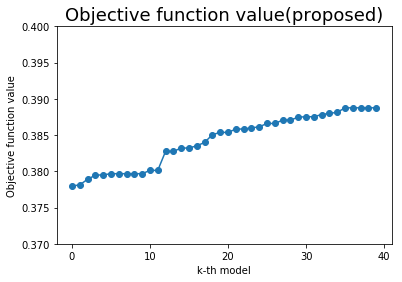

In [16]:
sort_func = sorted(scores)

index = np.arange(len(sort_func[:40]))
plt.plot(index, sort_func[:40], marker="o")
plt.ylim(0.37, 0.4)
plt.rcParams["font.size"] = 15
plt.title("Objective function value(proposed)")
plt.xlabel("k-th model")
plt.ylabel("Objective function value")

In [20]:
#print(sort_func[:40])
s = sort_func[3] - rho*2
s = s * err_num
print(s)
#for i in range(40):
    #print(sort_func[i])

2267.665


In [47]:
def calc_discrepancy(X, model_list, model):
    d_list = []
    for i in range(len(model_list)):
        model_prime = model_list[i]
        d = 0
        for j in range(len(X)):
            if model.flow(X[j]) != model_prime.flow(X[j]): 
                #print(model.flow(X[j]))
                #print(model_prime.flow(X[j]))
                d += 1
            
        d_list.append(d)
    
    return max(d_list) / len(X)

In [48]:
def calc_ambiguity(X, model_list, model):
    ambiguity = 0
    best_pred = model.predict(X)
    for i in range(len(X)):
        for h in model_list:
            if model.flow(X[i]) != h.flow(X[i]):
                ambiguity += 1
                break
                
    return ambiguity / len(X)

In [49]:
# 0 ~ 0.15 まで　0.01刻みで
discre_list = []
eps_list = []
num_model = []
for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * len(X)
    model_list = [ row[0] for row in uniq if row[1] <= rashomon]
    #print(rashomon, model_list)
    discrepancy = calc_discrepancy(X, model_list, best_model)
    #print(discrepancy)
    discre_list.append(discrepancy)
    eps_list.append(i)
    num_model.append(len(model_list))

0
5
10
15


In [50]:
print(discre_list)

[0.0, 0.09893666204345816, 0.1410078594544614, 0.18723994452149792, 0.2257666820773617, 0.2988133764832794, 0.32085067036523346, 0.3553706272152874, 0.4006780705809832, 0.4265680382185237, 0.43350285097857916, 0.46062567421790723, 0.4684851286793034, 0.4792726151949453, 0.5671135768223147, 0.5985513946678995]


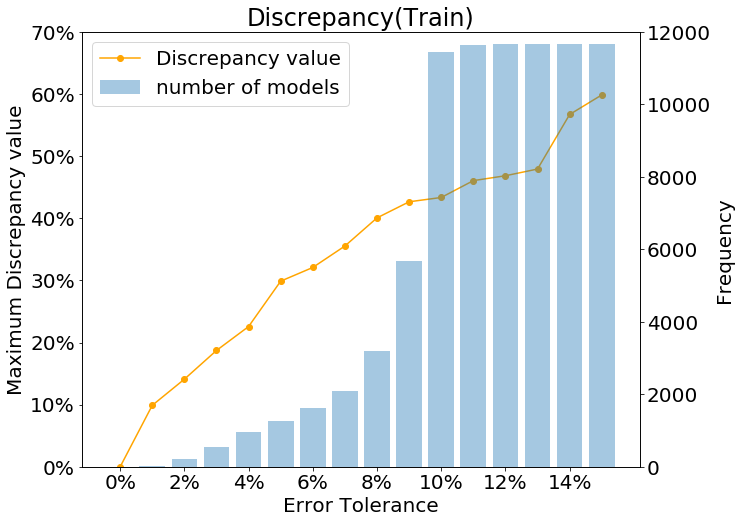

In [57]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
plt.rcParams["font.size"] = 20
plt.title("Discrepancy(Train)")
plt.xlabel("Error Tolerance")
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14], 
           ["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%"])
ax2 = ax1.twinx()
ax1.plot(eps_list, discre_list, color="orange", marker="o", label="Discrepancy value")
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 
ax1.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])
ax1.set_ylabel("Maximum Discrepancy value")
ax2.bar(eps_list, num_model, alpha=0.4, label="number of models")
ax2.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000]) 
ax2.set_ylabel("Frequency")
ax1.set_ylim(0, 0.7)
ax2.set_ylim(0,12000)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2,label1+label2, loc="upper left")

In [55]:
# 0 ~ 0.15 まで　0.01刻みで
amb_list = []
eps_list = []
num_model = []
for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * len(X)
    model_list = [ row[0] for row in uniq if row[1] <= rashomon]
    ambiguity = calc_ambiguity(X, model_list, best_model)
    amb_list.append(ambiguity)
    eps_list.append(i)
    num_model.append(len(model_list))

0
5
10
15


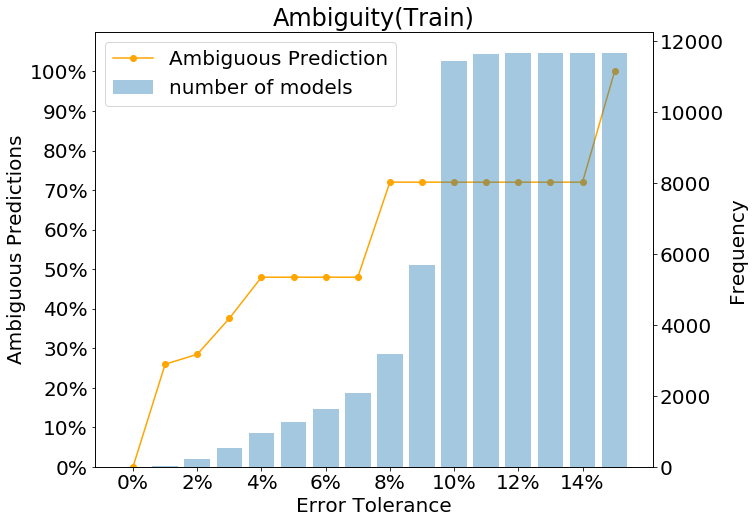

In [59]:
fig, ax3 = plt.subplots(1, 1, figsize=(10,8))
plt.rcParams["font.size"] = 20
#ax3 = fig.add_subplot(1, 2, 2)
plt.title("Ambiguity(Train)")
plt.xlabel("Error Tolerance")
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14], 
           ["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%"])
ax4 = ax3.twinx()
ax3.plot(eps_list, amb_list, color="orange", marker="o", label="Ambiguous Prediction")
ax3.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) 
ax3.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"])
ax3.set_ylabel("Ambiguous Predictions")
ax4.bar(eps_list, num_model, alpha=0.4, label="number of models")
ax4.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000]) 
ax4.set_ylabel("Frequency")
ax3.set_ylim(0, 1.1)
ax2.set_ylim(0,12000)
handler1, label1 = ax3.get_legend_handles_labels()
handler2, label2 = ax4.get_legend_handles_labels()
ax3.legend(handler1+handler2,label1+label2, loc="upper left")

In [22]:
discre_list = []
eps_list = []
num_model = []
for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * len(X)
    model_list = [ row[0] for row in uniq if row[1] <= rashomon]
    #print(rashomon, model_list)
    num_model.append(len(model_list))
    
num_model

0
5
10
15


[1,
 31,
 207,
 544,
 949,
 1252,
 1627,
 2085,
 3189,
 5679,
 11446,
 11641,
 11665,
 11667,
 11669,
 11677]